### Purpose of this exercise is to evaluate the ALSI (J200) to understand it better
### and discover and characteristics on it.  There is no specific purpose to the findings,
### simply both practising python and letting the data find and discoveries for me

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

***import the libraries and then import the data.<br>
The data source was a collection of 5min candles collected by capitalsynergy http://capitalsynergy.com/ <br>
over the period 20 July 1999 to 20 June 2018
***<br>

In [3]:
# The code was removed by Watson Studio for sharing.

,Date,Time,Open,High,Low,Close,Volume
0,1999/07/20,09:24:55,6520,6520,6520,6520,0
1,1999/07/20,09:26:55,6520,6520,6520,6520,0
2,1999/07/20,09:49:55,6520,6520,6520,6520,0
3,1999/07/20,09:55:55,6520,6520,6520,6520,0
4,1999/07/20,10:09:55,6517,6517,6516,6516,0


In [4]:
tmpAllData['DT'] = pd.to_datetime(tmpAllData['Date'] + ' ' + tmpAllData['Time'])
tmpAllData = tmpAllData.set_index('DT')

### Convert the 5min bars to EOD bars using the resample function

In [5]:
def createTables(valformat):
    #Different Columns have different calculation techniques
    # -- Add Closing --    
    tmp2 = tmpAllData.resample(valformat, level=0).last()
    df = tmp2[['Date','Close']].dropna()
   
    # -- Add Highs --
    tmp2 = tmpAllData.resample(valformat, level=0).max()
    df = pd.merge(df, tmp2[['Date','High']], on='Date').dropna()
   
    # -- Add Lows --
    tmp2 = tmpAllData.resample(valformat, level=0).min()
    df = pd.merge(df, tmp2[['Date','Low']], on='Date').dropna()
   
    # -- Add Open --
    tmp2 = tmpAllData.resample(valformat, level=0).first()
    df = pd.merge(df, tmp2[['Date','Open']], on='Date')

    #del tmp2
    return df

In [6]:
dfDay = createTables('D')
dfDay['rows'] = dfDay.index
dfDay.head()

#dfWk = createTables('W')
#print(dfWk)

,Date,Close,High,Low,Open,rows
0,1999/07/20,6478.0,6532.0,6470.0,6520.0,0
1,1999/07/21,6435.0,6450.0,6390.0,6400.0,1
2,1999/07/22,6422.0,6470.0,6420.0,6465.0,2
3,1999/07/23,6445.0,6487.0,6410.0,6410.0,3
4,1999/07/26,6410.0,6470.0,6390.0,6460.0,4


## Add Max drawdown and daily movements for further evaulation

In [7]:
dfDay = dfDay.set_index('Date')
dfDay['Date1'] = dfDay.index
dfDay['dayChng'] = (round((dfDay['Close']/dfDay['Open'])-1,4))*100
dfDay['peak'] = dfDay['High'].cummax()
dfDay['maxdd'] = (round((dfDay['Close']/dfDay['peak']) - 1,3))*100

dfDay['bin_dayChng'] = (round((dfDay['Close']/dfDay['Open'])-1,2))*100

#--Garbage Collection--
del dfDay['High']
del dfDay['Low']

***Interesting chart was plotting the frequency of the closes<br>
Simply shows how the markets mostly stayed in the<br>
10,000; 30,000 and 50,000 bin<br>
Areas where ALSI stayed the most, however the time there is getting shorter on each***

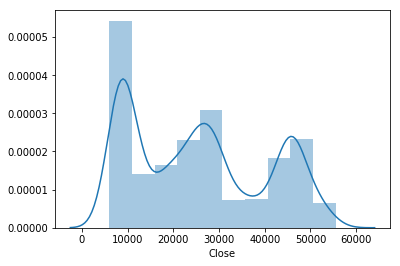

In [8]:
sns.distplot(dfDay['Close'],bins=10)

## Now to evaulate the expected daily moves
[grouping/binning the daily changes]

      bin_dayChng  Bucket
 0.0         1875       0
 1.0         1075       1
-1.0         1006      -1
-2.0          282      -2
 2.0          282       2
 3.0           78       3
-3.0           69      -3
 4.0           25       4
-4.0           16      -4
 5.0            8       5
-6.0            3      -6
-5.0            2      -5
 7.0            1       7
 6.0            1       6
-9.0            1      -9


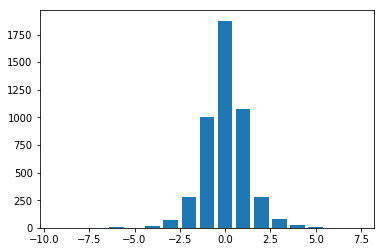

In [9]:
#--Average daily moves---
dftmp = pd.DataFrame(dfDay['bin_dayChng'].value_counts())
dftmp['Bucket'] = dftmp.index
dftmp.sort_values('Bucket')
dftmp['Bucket'] = dftmp['Bucket'].astype(int)
plt.bar(dftmp['Bucket'], dftmp['bin_dayChng'])
print(dftmp)

#--Garbage Collection--
del dfDay['peak']
del dfDay['bin_dayChng']

**Seems that most days really move in the 0-1% bucket<br>
Next in the +1 to +2% and finally the -1 to -2%. <br>
i.e. most of the time we move between -2 and +2** <br>

#### Finding/idea:
-Trading Options--> Why have a pure call when the probability<br>
-is low that we will exceed 5%<br>
-why not use a vertical spread instead?<br>

# Lets have a look at drawdowns on the market

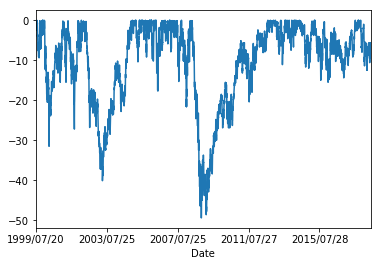

In [10]:
#Plot Max Drawdown
dfDay['maxdd'].plot()

In [25]:
print("Rows in total="+str(dfDay.shape))
print("Rows with highs="+str(dfDay[(dfDay['maxdd']>-1.0) & (dfDay['maxdd']<1.0)].shape))
print(round((591/4724)*100,2))


Rows in total=(4724, 6)
Rows with highs=(591, 6)
12.51


### only 13% of the time do we spend in "new high" territory
2002 period and 2007 period new highs were followed by 30%+ drawdowns<br>
2015 was only followed by a -10 drawdown

# Top10 Worst days on the ALSI

Notice how many of these days were during a major drawdown period<br>
i.e. worst days happen when selling is already happening

In [26]:
#Top10 Worst days on the ALSI
dfDay.sort_values('dayChng')[:].head(10)

,Close,Open,rows,Date1,dayChng,maxdd
Date,,,,,,
2001/09/11,7480.0,8182.0,534,2001/09/11,-8.58,-20.9
2008/10/15,19145.0,20445.0,2307,2008/10/15,-6.36,-39.5
2008/09/29,21345.0,22620.0,2295,2008/09/29,-5.64,-32.5
2002/07/31,8730.0,9240.0,755,2002/07/31,-5.52,-23.7
2001/12/21,10039.0,10545.0,605,2001/12/21,-4.80,-5.6
2009/01/14,18790.0,19720.0,2368,2009/01/14,-4.72,-40.6
2008/09/17,21990.0,23001.0,2288,2008/09/17,-4.40,-30.5
2011/08/04,26050.0,27215.0,3006,2011/08/04,-4.28,-17.7
2008/11/05,19700.0,20570.0,2322,2008/11/05,-4.23,-37.7


# Top10 Best days on the ALSI

Best days in the market also seem to be around >20% drawdowns<br>
Maybe that means volatility brings good and bad days?

In [27]:
#Top10 Best days on the ALSI
dfDay.sort_values('dayChng')[:].tail(10)

,Close,Open,rows,Date1,dayChng,maxdd
Date,,,,,,
2000/04/20,6720.0,6430.0,188,2000/04/20,4.51,-23.2
2008/11/25,18550.0,17745.0,2336,2008/11/25,4.54,-41.4
2008/01/30,25250.0,24151.0,2129,2008/01/30,4.55,-14.3
2006/06/20,18680.0,17850.0,1724,2006/06/20,4.65,-8.2
2001/12/14,10020.0,9550.0,601,2001/12/14,4.92,-0.3
2008/01/22,23650.0,22500.0,2123,2008/01/22,5.11,-19.7
2009/01/26,18500.0,17600.0,2376,2009/01/26,5.11,-41.5
2002/12/17,9015.0,8570.0,851,2002/12/17,5.19,-21.2
2009/03/19,18722.0,17700.0,2414,2009/03/19,5.77,-40.8


**Function to create linear regression line**

In [28]:
def cSlope(x): 
    return slope * x + intercept


In [29]:
slope, intercept, r, p, std_err = stats.linregress(dfDay['rows'],dfDay['dayChng'])
mymodel = list(map(cSlope, dfDay['rows']))
del r, p, std_err

**Slope at -0.0 doesnt particularly show any kind of bias towards the upside**

In [30]:
print('Slope= '+str(round(slope,4)))
print('intercept= '+str(round(intercept,4)))

Slope= -0.0
intercept= 0.0607


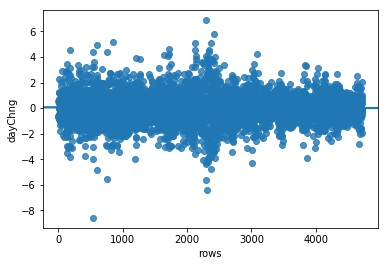

In [31]:
sns.regplot(x="rows", y="dayChng", data=dfDay);

# What happens a few days after ... ?

In [32]:
# Days Later
dfDay['later05'] = dfDay.Close.shift(-5)
dfDay['later15'] = dfDay.Close.shift(-15)
dfDay['later25'] = dfDay.Close.shift(-25)

dfDay['later05gain'] = (round((dfDay['later05']/dfDay['Close'])-1,4))*100
dfDay['later15gain'] = (round((dfDay['later15']/dfDay['Close'])-1,4))*100
dfDay['later25gain'] = (round((dfDay['later25']/dfDay['Close'])-1,4))*100

In [38]:
dfDay.tail()

,Close,Open,rows,Date1,dayChng,maxdd,later05,later15,later25,later05gain,later15gain,later25gain,sma200,ema200
Date,,,,,,,,,,,,,,
2018/06/14,52378.0,52184.0,4719,2018/06/14,0.37,-5.7,NaN,NaN,NaN,NaN,NaN,NaN,51816.695,51013.448709
2018/06/15,51302.0,52325.0,4720,2018/06/15,-1.96,-7.6,NaN,NaN,NaN,NaN,NaN,NaN,51823.800,51016.319866
2018/06/18,51114.0,51130.0,4721,2018/06/18,-0.03,-8.0,NaN,NaN,NaN,NaN,NaN,NaN,51830.840,51017.291808
2018/06/19,50304.0,50427.0,4722,2018/06/19,-0.24,-9.4,NaN,NaN,NaN,NaN,NaN,NaN,51835.360,51010.194377
2018/06/20,50386.0,50540.0,4723,2018/06/20,-0.30,-9.3,NaN,NaN,NaN,NaN,NaN,NaN,51838.560,51003.983488


**Plottting the average % gain after 5 days on the market**

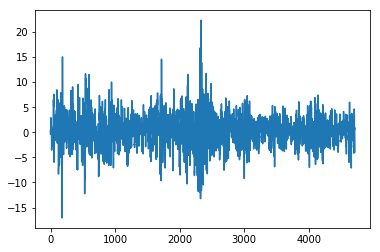

In [39]:
plt.plot(dfDay['rows'], dfDay['later05gain'], label='Date1')

##### Charting the 200 EMA on the ALSI
##### Will be used to test whether difference between EMA and Closing can be used as a predictor

In [35]:
dfDay['sma200'] = dfDay.Close.rolling(200).mean()
dfDay['ema200'] = dfDay.Close.ewm(span=200, adjust=False).mean()

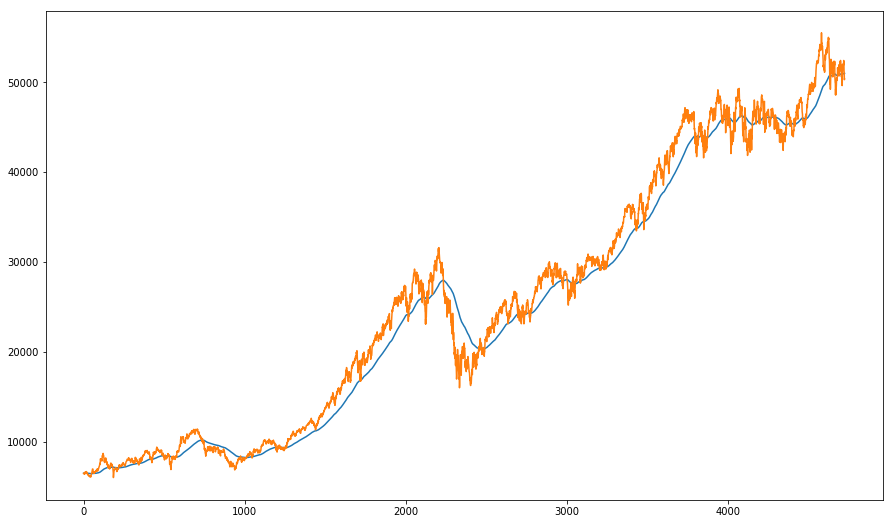

In [36]:
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(dfDay['rows'], dfDay['ema200'], label='Price')
ax.plot(dfDay['rows'], dfDay['Close'], label='Price')

In [37]:
dfDay.head()

,Close,Open,rows,Date1,dayChng,maxdd,later05,later15,later25,later05gain,later15gain,later25gain,sma200,ema200
Date,,,,,,,,,,,,,,
1999/07/20,6478.0,6520.0,0,1999/07/20,-0.64,-0.8,6455.0,6515.0,6392.0,-0.36,0.57,-1.33,NaN,6478.000000
1999/07/21,6435.0,6400.0,1,1999/07/21,0.55,-1.5,6470.0,6647.0,6375.0,0.54,3.29,-0.93,NaN,6477.572139
1999/07/22,6422.0,6465.0,2,1999/07/22,-0.67,-1.7,6412.0,6665.0,6325.0,-0.16,3.78,-1.51,NaN,6477.019183
1999/07/23,6445.0,6410.0,3,1999/07/23,0.55,-1.3,6460.0,6655.0,6330.0,0.23,3.26,-1.78,NaN,6476.700584
1999/07/26,6410.0,6460.0,4,1999/07/26,-0.77,-1.9,6450.0,6564.0,6267.0,0.62,2.40,-2.23,NaN,6476.036896


**Calculate difference between Close and EMA<br>
in both point value and % terms**

In [40]:
dfDay['diff200'] = dfDay['Close']-dfDay['ema200']
dfDay['diff200'] = dfDay['diff200'].shift(1)

dfDay['diff200%'] = (round((dfDay['Close']/dfDay['ema200'])-1,2))*100
dfDay['diff200%'] = dfDay['diff200%'].shift(1)

dfDay = dfDay.dropna()

In [42]:
#---Garbage Collection---

del dfDay['later05'] 
del dfDay['later15'] 
del dfDay['later25'] 

del dfDay['later05gain'] 
del dfDay['later15gain'] 
del dfDay['later25gain'] 

In [43]:
dfDay.head()

,Close,Open,rows,Date1,dayChng,maxdd,sma200,ema200,diff200,diff200%
Date,,,,,,,,,,
2000/05/11,7045.0,7010.0,199,2000/05/11,0.50,-19.5,7060.930,7110.683181,-6.343313,-0.0
2000/05/12,7020.0,7010.0,200,2000/05/12,0.14,-19.8,7063.640,7109.780860,-65.683181,-1.0
2000/05/15,6975.0,7015.0,201,2000/05/15,-0.57,-20.3,7066.340,7108.439757,-89.780860,-1.0
2000/05/16,7058.0,7060.0,202,2000/05/16,-0.03,-19.4,7069.520,7107.937869,-133.439757,-2.0
2000/05/17,6950.0,7020.0,203,2000/05/17,-1.00,-20.6,7072.045,7106.366348,-49.937869,-1.0


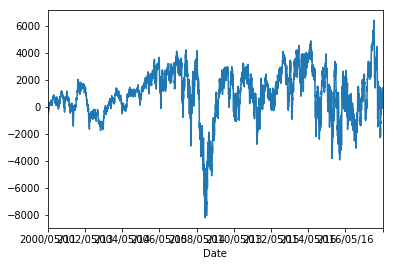

In [44]:
#ALSI points difference between EMA and Close
dfDay['diff200'].plot.line()


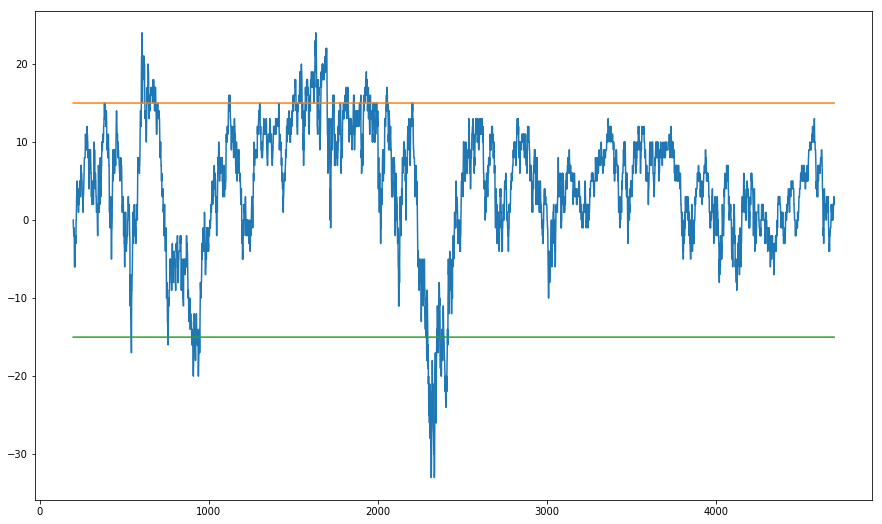

In [45]:
#ALSI points difference between EMA and Close in %
dfDay['L1'] = 15
dfDay['L2'] = -15

fig, ax = plt.subplots(figsize=(15,9))
ax.plot(dfDay['rows'], dfDay['diff200%'], label='Price')
ax.plot(dfDay['rows'], dfDay['L1'], label='Price')
ax.plot(dfDay['rows'], dfDay['L2'], label='Price')

### ALSI Anchored to EMA200
ALSI in % terms from EMA does seem to be more range bound<br>
as the values oscillate between +15 and -15 before returning back to zero
Absolute extrems seem to between 20 and -20

**Days when EMA to Close differed by more than -20%**

In [47]:
dfDay[dfDay['diff200%']<-20]

,Close,Open,rows,Date1,dayChng,maxdd,sma200,ema200,diff200,diff200%,L1,L2
Date,,,,,,,,,,,,
2008/10/03,20999.0,20550.0,2299,2008/10/03,2.18,-33.6,26972.025,26250.405120,-5558.183061,-21.0,15,-15
2008/10/07,19900.0,20035.0,2301,2008/10/07,-0.67,-37.1,26910.580,26123.672512,-6386.221985,-24.0,15,-15
2008/10/08,19635.0,18892.0,2302,2008/10/08,3.93,-38.0,26881.355,26059.108607,-6223.672512,-24.0,15,-15
2008/10/09,19740.0,19750.0,2303,2008/10/09,-0.05,-37.6,26850.765,25996.231904,-6424.108607,-25.0,15,-15
2008/10/10,19305.0,18800.0,2304,2008/10/10,2.69,-39.0,26811.540,25929.652482,-6256.231904,-24.0,15,-15
2008/10/13,19985.0,20100.0,2305,2008/10/13,-0.57,-36.8,26774.365,25870.501711,-6624.652482,-26.0,15,-15
2008/10/14,20515.0,20700.0,2306,2008/10/14,-0.89,-35.2,26738.920,25817.213137,-5885.501711,-23.0,15,-15
2008/10/15,19145.0,20445.0,2307,2008/10/15,-6.36,-39.5,26698.295,25750.822956,-5302.213137,-21.0,15,-15
2008/10/16,18600.0,18750.0,2308,2008/10/16,-0.80,-41.2,26658.295,25679.670489,-6605.822956,-26.0,15,-15
